In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy.stats import mode

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 

pd.options.mode.chained_assignment = None

pd.set_option('display.max_rows', 500)

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score

In [2]:
raw = pd.read_csv('tr_eikon_eod_data.csv', 
                 index_col = 0, parse_dates = True)
print(raw.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2216 entries, 2010-01-01 to 2018-06-29
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL.O  2138 non-null   float64
 1   MSFT.O  2138 non-null   float64
 2   INTC.O  2138 non-null   float64
 3   AMZN.O  2138 non-null   float64
 4   GS.N    2138 non-null   float64
 5   SPY     2138 non-null   float64
 6   .SPX    2138 non-null   float64
 7   .VIX    2138 non-null   float64
 8   EUR=    2216 non-null   float64
 9   XAU=    2211 non-null   float64
 10  GDX     2138 non-null   float64
 11  GLD     2138 non-null   float64
dtypes: float64(12)
memory usage: 225.1 KB
None


In [3]:
colnames = ['AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GS.N']
tickers = ["AAPL", "MSFT", "INTC", "AMZN", "GS"]

In [4]:
ext_data = yf.download("AAPL MSFT INTC AMZN GS", start="2010-01-01", end="2018-07-01")

print(ext_data.info())

[*********************100%%**********************]  5 of 5 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2138 entries, 2010-01-04 to 2018-06-29
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Adj Close, AAPL)  2138 non-null   float64
 1   (Adj Close, AMZN)  2138 non-null   float64
 2   (Adj Close, GS)    2138 non-null   float64
 3   (Adj Close, INTC)  2138 non-null   float64
 4   (Adj Close, MSFT)  2138 non-null   float64
 5   (Close, AAPL)      2138 non-null   float64
 6   (Close, AMZN)      2138 non-null   float64
 7   (Close, GS)        2138 non-null   float64
 8   (Close, INTC)      2138 non-null   float64
 9   (Close, MSFT)      2138 non-null   float64
 10  (High, AAPL)       2138 non-null   float64
 11  (High, AMZN)       2138 non-null   float64
 12  (High, GS)         2138 non-null   float64
 13  (High, INTC)       2138 non-null   float64
 14  (High, MSFT)       2138 non-null   float64
 15  (Low, AAPL)        2138 non-null   float64
 16  (Low, 

In [5]:
data = raw[colnames]

print(ext_data["Open"]["AAPL"])
print(ext_data["Close"]["AAPL"])
print(ext_data["High"]["AAPL"])
print(ext_data["Low"]["AAPL"])
print(data["AAPL.O"])
print(data[data.isna().any(axis=1)])
print(ext_data["Close"])

rets = pd.DataFrame()

for stock in colnames:
    data[f"{stock} ret"] = np.log(data[stock] / data[stock].shift(1))

data.dropna(inplace=True)    

for stock in colnames:
    data[f"{stock} dir"] = np.sign(data[f"{stock} ret"]).astype(int)

Date
2010-01-04     7.622500
2010-01-05     7.664286
2010-01-06     7.656429
2010-01-07     7.562500
2010-01-08     7.510714
                ...    
2018-06-25    45.849998
2018-06-26    45.747501
2018-06-27    46.307499
2018-06-28    46.025002
2018-06-29    46.572498
Name: AAPL, Length: 2138, dtype: float64
Date
2010-01-04     7.643214
2010-01-05     7.656429
2010-01-06     7.534643
2010-01-07     7.520714
2010-01-08     7.570714
                ...    
2018-06-25    45.542500
2018-06-26    46.107498
2018-06-27    46.040001
2018-06-28    46.375000
2018-06-29    46.277500
Name: AAPL, Length: 2138, dtype: float64
Date
2010-01-04     7.660714
2010-01-05     7.699643
2010-01-06     7.686786
2010-01-07     7.571429
2010-01-08     7.571429
                ...    
2018-06-25    46.230000
2018-06-26    46.632500
2018-06-27    46.820000
2018-06-28    46.552502
2018-06-29    46.797501
Name: AAPL, Length: 2138, dtype: float64
Date
2010-01-04     7.585000
2010-01-05     7.616071
2010-01-06     7.

In [6]:
stock_bins = {}

for stock in colnames:
    mean = data[f'{stock} ret'].mean()
    std = data[f'{stock } ret'].std()
    stock_bins[stock] = [mean - std, mean, mean + std]

lag_feat = []
for stock in colnames:
    for i in range(1,11):
        feat = f'{stock} lag_' + str(i)
        data[feat] = np.digitize(data[f'{stock} ret'].shift(i), stock_bins[stock])
        lag_feat.append(feat)

data

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,AAPL.O ret,MSFT.O ret,INTC.O ret,AMZN.O ret,GS.N ret,...,GS.N lag_1,GS.N lag_2,GS.N lag_3,GS.N lag_4,GS.N lag_5,GS.N lag_6,GS.N lag_7,GS.N lag_8,GS.N lag_9,GS.N lag_10
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,30.625684,30.960,20.87,134.690,176.14,0.001727,0.000323,-0.000479,0.005883,0.017525,...,3,3,3,3,3,3,3,3,3,3
2010-01-06,30.138541,30.770,20.80,132.250,174.26,-0.016034,-0.006156,-0.003360,-0.018282,-0.010731,...,3,3,3,3,3,3,3,3,3,3
2010-01-07,30.082827,30.452,20.60,130.000,177.67,-0.001850,-0.010389,-0.009662,-0.017160,0.019379,...,1,3,3,3,3,3,3,3,3,3
2010-01-08,30.282827,30.660,20.83,133.520,174.31,0.006626,0.006807,0.011103,0.026717,-0.019093,...,3,1,3,3,3,3,3,3,3,3
2010-01-11,30.015684,30.270,20.95,130.308,171.56,-0.008861,-0.012802,0.005744,-0.024350,-0.015902,...,0,3,1,3,3,3,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-25,182.170000,98.390,50.71,1663.150,221.54,-0.014983,-0.020323,-0.034690,-0.031090,-0.020020,...,1,1,1,1,1,1,1,2,1,2
2018-06-26,184.430000,99.080,49.67,1691.090,221.58,0.012330,0.006988,-0.020722,0.016660,0.000181,...,0,1,1,1,1,1,1,1,2,1
2018-06-27,184.160000,97.540,48.76,1660.510,220.18,-0.001465,-0.015665,-0.018491,-0.018249,-0.006338,...,2,0,1,1,1,1,1,1,1,2


In [7]:
def calculate_rsi(prices, period=14):
    deltas = prices.diff()
    gains = deltas.where(deltas > 0, 0)
    losses = -deltas.where(deltas < 0, 0)
    
    avg_gain = gains.rolling(window=period).mean()
    avg_loss = losses.rolling(window=period).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

rsi_bins = {}

for stock in colnames:
    feat = f"{stock} rsi"
    data[feat] = calculate_rsi(data[stock])
    mean = data[feat].mean()
    std = data[feat].std()
    rsi_bins[stock] = [mean - std, mean, mean + std]
    
    data[feat] = data[feat].shift(1)

rsi_feat = [f"{stock} rsi"]

In [8]:
def moving_average(data, window_short=20, window_long=100):
    """
    Calculate short-term and long-term moving averages.

    Parameters:
    - data: List or array-like object containing the time series data.
    - window_short: Integer specifying the window size for the short-term moving average.
    - window_long: Integer specifying the window size for the long-term moving average.

    Returns:
    - short_ma: List containing the short-term moving averages.
    - long_ma: List containing the long-term moving averages.
    """

    # Calculate short-term moving average
    short_ma = data.rolling(window=window_short).mean()

    # Calculate long-term moving average
    long_ma = data.rolling(window=window_long).mean()

    return short_ma, long_ma

for stock in colnames:
    short, long = moving_average(data[stock])
    data[f'{stock} SMA'] = np.where(short > long, 1, -1)
    data[f"{stock} SMA"] = data[f"{stock} SMA"].shift(-100).shift(101)

ma_feat = [f"{stock} SMA" for stock in colnames]


In [9]:
def simple_sma_trade(data, window=125, tolerance=0.01):
    sma = data.rolling(window=window).mean()
    threshold = tolerance * sma

    return np.where(data > sma, 1, -1)

for stock in colnames:
    data[f"{stock} SMA trade"] = simple_sma_trade(data[stock])
    data[f"{stock} SMA trade"] = data[f"{stock} SMA trade"].shift(-125).shift(126)

sma_feat = [f"{stock} SMA trade" for stock in colnames]

In [10]:
feat_data = data.dropna()

for stock in colnames:
    feat = f"{stock} digi-rsi"
    rsi = f"{stock} rsi"
    feat_data[feat] = np.digitize(feat_data[rsi], bins=rsi_bins[stock])

rsi_feat = [f"{stock} digi-rsi" for stock in colnames]

In [11]:
def print_data(string, data):
    print("-" * 100)
    print(string)
    print("-" * 100)
    print(data)

----------------------------------------------------------------------------------------------------
Returns:
----------------------------------------------------------------------------------------------------
AAPL.O ret    1.112759
MSFT.O ret    0.781146
INTC.O ret    1.128317
AMZN.O ret    0.991707
GS.N ret      1.068941
dtype: float64
----------------------------------------------------------------------------------------------------
RandomForest returns:
----------------------------------------------------------------------------------------------------
AAPL.O ret    1.071160
MSFT.O ret    1.042955
INTC.O ret    0.899741
AMZN.O ret    2.008307
GS.N ret      1.059098
dtype: float64
----------------------------------------------------------------------------------------------------
False predictions:
----------------------------------------------------------------------------------------------------
AAPL.O dir    197
MSFT.O dir    200
INTC.O dir    183
AMZN.O dir    183
GS.N dir    

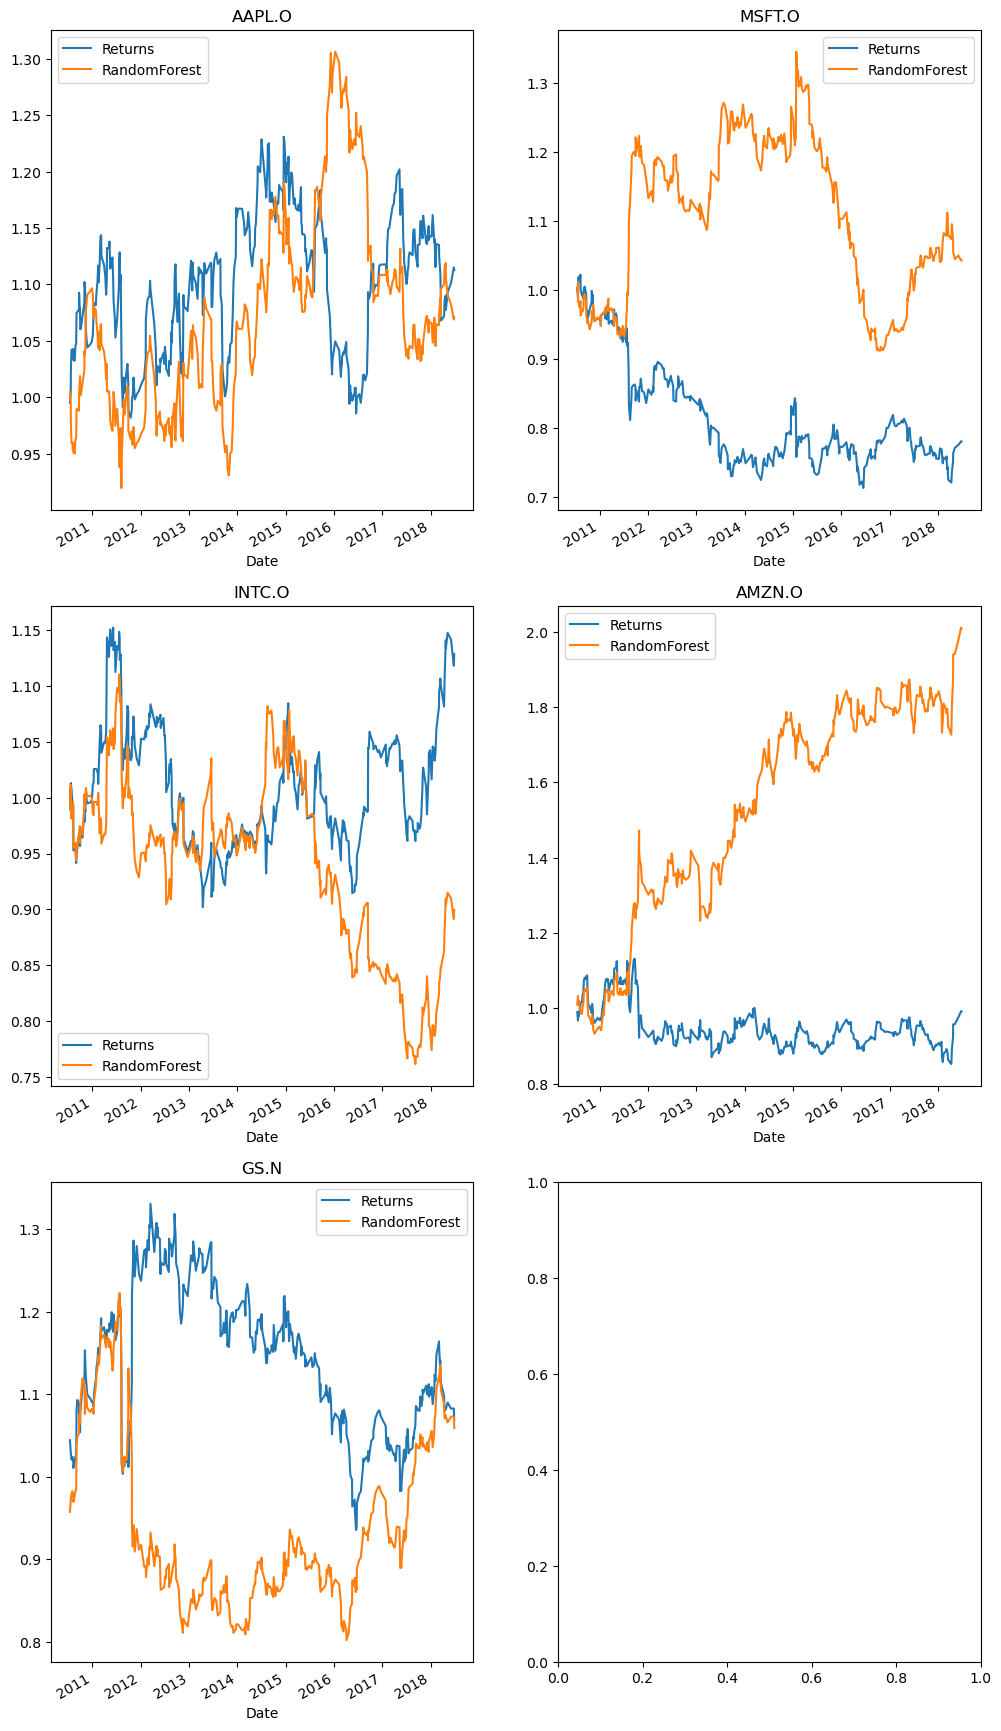

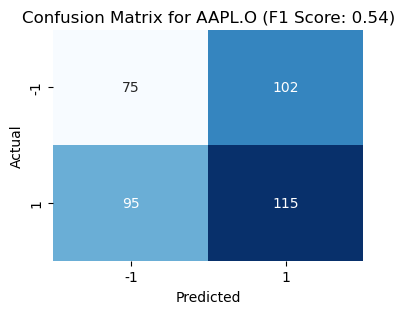

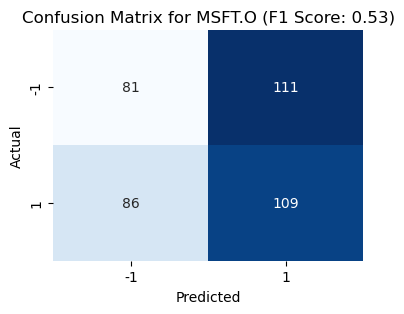

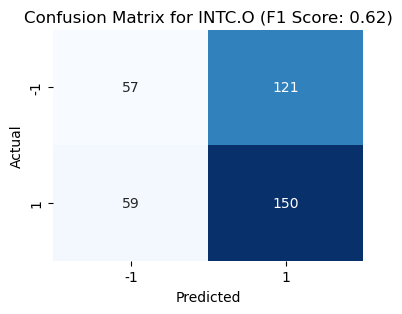

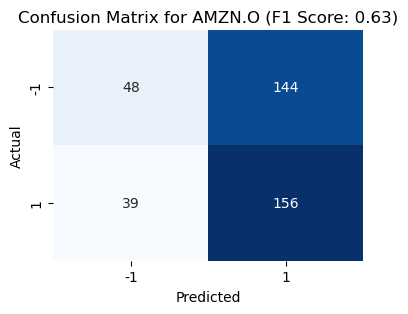

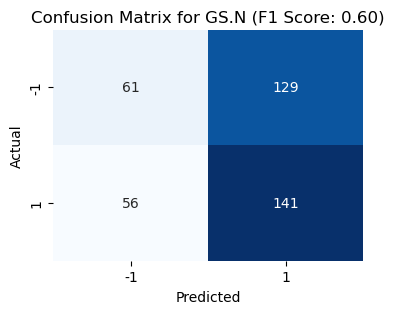

In [27]:
data_train, data_test = train_test_split(feat_data, 
                                         test_size = 0.2,
                                         random_state = 0)
features = ma_feat + sma_feat + lag_feat + rsi_feat

roll = 3
# test_split = len(data) // 5

# data_train = feat_data[:- test_split]
# data_test = feat_data[-test_split:]

data_train = data_train.copy().sort_index()
data_test = data_test.copy().sort_index()

training = data_train[features]
testing = data_test[features]

training_res = data_train[[f"{stock} dir" for stock in colnames]]
testing_res = data_test[[f"{stock} dir" for stock in colnames]]

model = RandomForestClassifier(max_depth=5, min_samples_leaf=5)

model.fit(training, training_res)

preds = model.predict(testing)
results = pd.DataFrame(data=preds).rolling(window=roll, min_periods=1).apply(lambda x: mode(x)[0]).values


print_data("Returns:", data_test[[f"{stock} ret" for stock in colnames]].sum().apply(np.exp))

print_data("RandomForest returns:", (results * data_test[[f"{stock} ret" for stock in colnames]]).sum().apply(np.exp))

print_data("False predictions:", (results != data_test[[f"{stock} dir" for stock in colnames]]).sum())

print_data("Total rows:", results.shape[0])

feature_importances = model.feature_importances_
print_data("Feature importance:", pd.DataFrame(data=feature_importances, index=features, columns=["Importance"]).sort_values("Importance", ascending=False))

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,24))

for i, stock in enumerate(colnames):
    data_test[f"{stock} ret"].cumsum().apply(np.exp).plot(ax=axes[i // 2, i % 2], label="returns")
    (results[:,i] * data_test[f"{stock} ret"]).cumsum().apply(np.exp).plot(ax=axes[i // 2, i % 2], label="RandomForest")

    # (data_test[f"{stock} ret"] * data_test[f"{stock} dir"]).cumsum().apply(np.exp).plot(ax=axes[i // 2, i % 2], label="Optimal")
    
    axes[i // 2, i % 2].legend(["Returns", "RandomForest"])
    axes[i // 2, i % 2].set_title(stock)

def calculate_f1_score(conf_matrix):
    true_positives = conf_matrix[1, 1]
    false_positives = conf_matrix[0, 1]
    false_negatives = conf_matrix[1, 0]

    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)

    f1_score = 2 * (precision * recall) / (precision + recall)
    
    return f1_score

# Iterate over each column and create confusion matrix
for i, stock in enumerate(colnames):
    # Create confusion matrix
    conf_matrix = np.zeros((2, 2))
    for actual, predicted in zip(data_test[f"{stock} dir"].values, results[:, i]):
        actual_index = 0 if actual == -1 else 1
        predicted_index = 0 if predicted == -1 else 1
        conf_matrix[actual_index, predicted_index] += 1

    # Calculate F1 score
    f1_score = calculate_f1_score(conf_matrix)

    # Plot the confusion matrix as a heatmap
    plt.figure(figsize=(4, 3))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False, xticklabels=['-1', '1'], yticklabels=['-1', '1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {stock} (F1 Score: {f1_score:.2f})')
    plt.show()



AAPL.O
----------------------------------------------------------------------------------------------------
Returns:
----------------------------------------------------------------------------------------------------
AAPL.O ret    1.112759
dtype: float64
----------------------------------------------------------------------------------------------------
RandomForest returns:
----------------------------------------------------------------------------------------------------
AAPL.O ret    1.166134
dtype: float64
----------------------------------------------------------------------------------------------------
False predictions:
----------------------------------------------------------------------------------------------------
AAPL.O dir    189
dtype: int64
----------------------------------------------------------------------------------------------------
Total rows:
----------------------------------------------------------------------------------------------------
387
------------

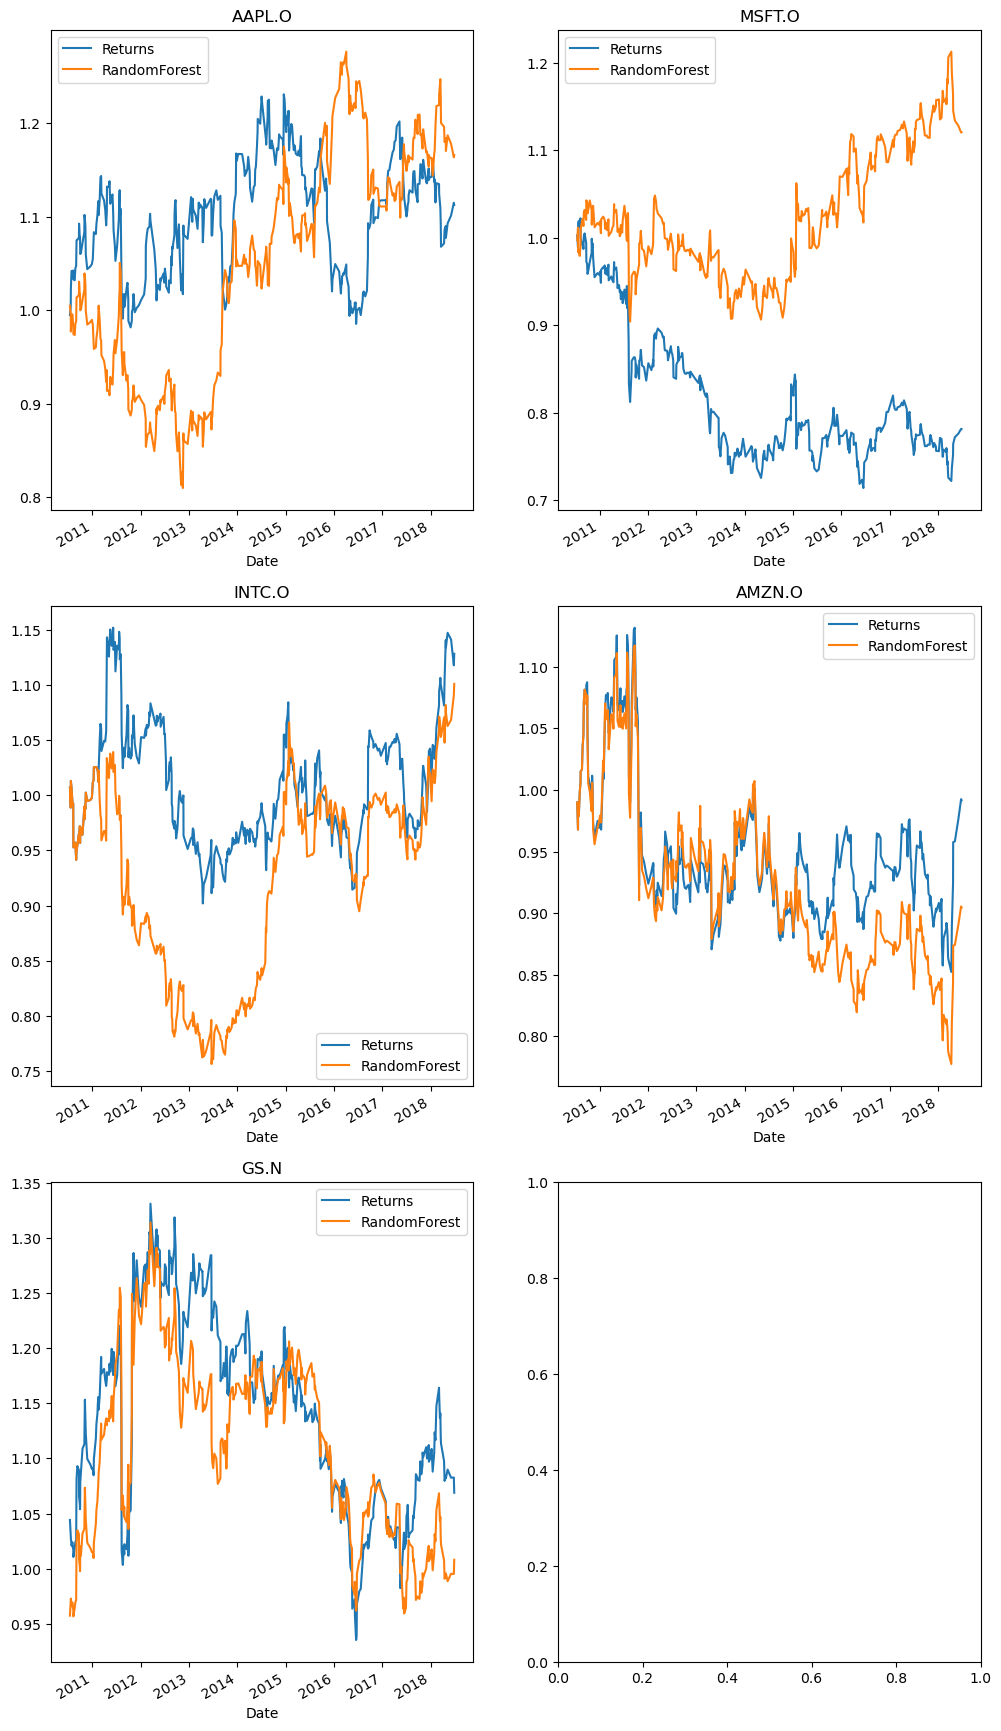

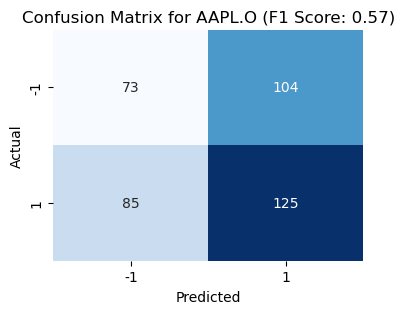

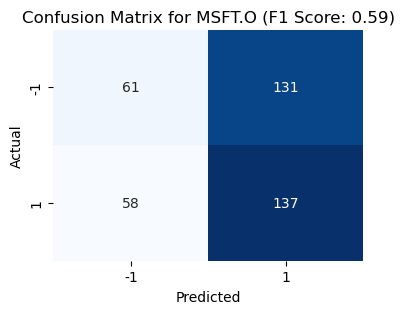

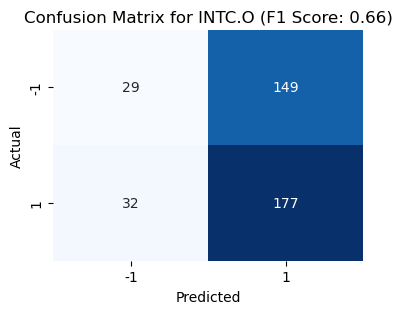

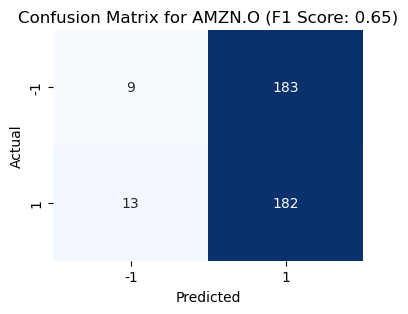

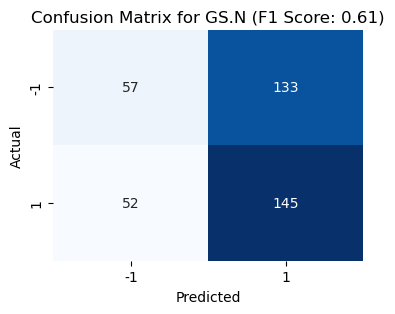

In [13]:
data_train, data_test = train_test_split(feat_data, 
                                         test_size = 0.2,
                                         random_state = 0)
features = ma_feat + sma_feat + lag_feat + rsi_feat

roll = 3

data_train = data_train.copy().sort_index()
data_test = data_test.copy().sort_index()

training = data_train[features]
testing = data_test[features]

training_res = data_train[[f"{stock} dir" for stock in colnames]]
testing_res = data_test[[f"{stock} dir" for stock in colnames]]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,24))

for i, stock in enumerate(colnames):
    feat = list(filter(lambda x: stock in x, features))

    model = RandomForestClassifier(max_depth=5, min_samples_leaf=5)

    model.fit(training[feat], training_res[f"{stock} dir"])

    preds = model.predict(testing[feat])
    results = pd.DataFrame(data=preds).rolling(window=roll, min_periods=1).apply(lambda x: mode(x)[0]).values

    print(stock)
    print_data("Returns:", data_test[[f"{stock} ret"]].sum().apply(np.exp))
    print_data("RandomForest returns:", (results * data_test[[f"{stock} ret"]]).sum().apply(np.exp))
    print_data("False predictions:", (results != data_test[[f"{stock} dir"]]).sum())
    print_data("Total rows:", results.shape[0])

    feature_importances = model.feature_importances_
    print_data("Feature importance:", pd.DataFrame(data=feature_importances, index=feat, columns=["Importance"]).sort_values("Importance", ascending=False))

    data_test[f"{stock} ret"].cumsum().apply(np.exp).plot(ax=axes[i // 2, i % 2], label="returns")
    (results[:, 0] * data_test[f"{stock} ret"]).cumsum().apply(np.exp).plot(ax=axes[i // 2, i % 2], label="RandomForest")

    axes[i // 2, i % 2].legend(["Returns", "RandomForest"])
    axes[i // 2, i % 2].set_title(stock)

    conf_matrix = np.zeros((2, 2))
    for actual, predicted in zip(data_test[f"{stock} dir"].values, results[:, 0]):
        actual_index = 0 if actual == -1 else 1
        predicted_index = 0 if predicted == -1 else 1
        conf_matrix[actual_index, predicted_index] += 1

    # Calculate F1 score
    f1_score = calculate_f1_score(conf_matrix)

    # Plot the confusion matrix as a heatmap
    plt.figure(figsize=(4, 3))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False, xticklabels=['-1', '1'], yticklabels=['-1', '1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {stock} (F1 Score: {f1_score:.2f})')
    
plt.show()

In [14]:
def simulate_model(it, stocks=colnames, data=feat_data, train=data_train, test=data_test, ran_split=False, feat=features, rerun=0, rolling_parse=1):

    lst = []
    for stock in stocks:
        lst += list(filter(lambda x: stock in x, feat))
    feat = lst

    sim = pd.DataFrame(columns=[f"{stock} ret" for stock in stocks])
    improv = pd.DataFrame(columns=[f"{stock} ret" for stock in stocks])
    false_pred = np.zeros((it * (1 + rerun), len(stocks)))
    f1s = np.zeros((it * (1 + rerun), len(stocks)))
    imp = pd.DataFrame(index=feat)
    run = 0

    while True:
        if ran_split:
            train, test = train_test_split(data, 
                                                test_size = 0.2)

        train = train.copy().sort_index()
        test = test.copy().sort_index()

        training = train[feat]
        testing = test[feat]

        training_res = train[[f"{stock} dir" for stock in stocks]]

        for i in range(it):
            model = RandomForestClassifier(max_depth=5, min_samples_leaf=5)
            model.fit(training, training_res)

            results = model.predict(testing)
            results = pd.DataFrame(data=results).rolling(window=rolling_parse, min_periods=1).apply(lambda x: mode(x)[0]).values
            rets = test[[f"{stock} ret" for stock in stocks]].sum().apply(np.exp)

            pred_rets = (results * test[[f"{stock} ret" for stock in stocks]]).sum().apply(np.exp)

            sim = pd.concat([(pred_rets - rets).to_frame().T, sim], ignore_index=True)

            improv = pd.concat([improv, np.sign(pred_rets - rets).astype(int).to_frame().T], ignore_index=True)
            false_pred[i + run * it, :] = (results != test[[f"{stock} dir" for stock in stocks]]).sum()

            importances = pd.Series(model.feature_importances_, index=training.columns)
            imp = pd.concat([imp, importances], axis=1)

            for j, stock in enumerate(stocks):
                # Create confusion matrix
                conf_matrix = np.zeros((2, 2))
                for actual, predicted in zip(test[f"{stock} dir"].values, results[:, j]):
                    actual_index = 0 if actual == -1 else 1
                    predicted_index = 0 if predicted == -1 else 1
                    conf_matrix[actual_index, predicted_index] += 1

                # Calculate F1 score
                f1_score = calculate_f1_score(conf_matrix)
                f1s[i + run * it, j] = f1_score
        run += 1
        if run <= rerun:
            continue
        else:
            break

    false_pred = pd.DataFrame(data=false_pred, columns=[stock for stock in stocks], index=[j for j in range(it * (1 + rerun))])

    sorted_imp = (imp.sum(axis=1) / (it * (1 + rerun))).sort_values(ascending=False)

    print_data("Mean improvement: ", sim.mean())

    print_data("std dev of improvements: ", sim.std())

    print_data("Number of improvements: ", improv.replace(-1, 0).sum(axis=0))

    print_data("Mean false predictions: ", false_pred.mean())

    print_data("std dev false predictions: ", false_pred.std())

    print_data("Mean feature importance", sorted_imp)

    print_data("std dev feature importance", imp.std(axis=1).reindex(sorted_imp.index))

    print_data("Mean f1 score:", pd.DataFrame(data=(f1s.sum(axis=0) / (it * (1 + rerun))), index=[f"{stock} f1" for stock in stocks]))

    print_data("std dev of f1 scores: ", pd.DataFrame(data=(f1s.std(axis=0)), index=[f"{stock} f1" for stock in stocks]))

In [15]:
itr = 20
reruns = 20
ran_split = True
roll = 3

In [16]:
simulate_model(itr, stocks=["AAPL.O"], ran_split=ran_split, rerun=reruns, rolling_parse=roll)

----------------------------------------------------------------------------------------------------
Mean improvement: 
----------------------------------------------------------------------------------------------------
AAPL.O ret   -0.110532
dtype: float64
----------------------------------------------------------------------------------------------------
std dev of improvements: 
----------------------------------------------------------------------------------------------------
AAPL.O ret    0.425639
dtype: float64
----------------------------------------------------------------------------------------------------
Number of improvements: 
----------------------------------------------------------------------------------------------------
AAPL.O ret    158
dtype: int64
----------------------------------------------------------------------------------------------------
Mean false predictions: 
-------------------------------------------------------------------------------------------

In [17]:
simulate_model(itr, stocks=["MSFT.O"], ran_split=ran_split, rerun=reruns, rolling_parse=roll)

----------------------------------------------------------------------------------------------------
Mean improvement: 
----------------------------------------------------------------------------------------------------
MSFT.O ret   -0.107579
dtype: float64
----------------------------------------------------------------------------------------------------
std dev of improvements: 
----------------------------------------------------------------------------------------------------
MSFT.O ret    0.32986
dtype: float64
----------------------------------------------------------------------------------------------------
Number of improvements: 
----------------------------------------------------------------------------------------------------
MSFT.O ret    142
dtype: int64
----------------------------------------------------------------------------------------------------
Mean false predictions: 
--------------------------------------------------------------------------------------------

In [18]:
simulate_model(itr, stocks=["INTC.O"], ran_split=ran_split, rerun=reruns, rolling_parse=roll)

----------------------------------------------------------------------------------------------------
Mean improvement: 
----------------------------------------------------------------------------------------------------
INTC.O ret   -0.059081
dtype: float64
----------------------------------------------------------------------------------------------------
std dev of improvements: 
----------------------------------------------------------------------------------------------------
INTC.O ret    0.196857
dtype: float64
----------------------------------------------------------------------------------------------------
Number of improvements: 
----------------------------------------------------------------------------------------------------
INTC.O ret    160
dtype: int64
----------------------------------------------------------------------------------------------------
Mean false predictions: 
-------------------------------------------------------------------------------------------

In [19]:
simulate_model(itr, stocks=["AMZN.O"], ran_split=ran_split, rerun=reruns, rolling_parse=roll)

----------------------------------------------------------------------------------------------------
Mean improvement: 
----------------------------------------------------------------------------------------------------
AMZN.O ret   -0.228567
dtype: float64
----------------------------------------------------------------------------------------------------
std dev of improvements: 
----------------------------------------------------------------------------------------------------
AMZN.O ret    0.487161
dtype: float64
----------------------------------------------------------------------------------------------------
Number of improvements: 
----------------------------------------------------------------------------------------------------
AMZN.O ret    140
dtype: int64
----------------------------------------------------------------------------------------------------
Mean false predictions: 
-------------------------------------------------------------------------------------------

In [20]:
simulate_model(itr, stocks=["GS.N"], ran_split=ran_split, rerun=reruns, rolling_parse=roll)

----------------------------------------------------------------------------------------------------
Mean improvement: 
----------------------------------------------------------------------------------------------------
GS.N ret   -0.146648
dtype: float64
----------------------------------------------------------------------------------------------------
std dev of improvements: 
----------------------------------------------------------------------------------------------------
GS.N ret    0.363465
dtype: float64
----------------------------------------------------------------------------------------------------
Number of improvements: 
----------------------------------------------------------------------------------------------------
GS.N ret    142
dtype: int64
----------------------------------------------------------------------------------------------------
Mean false predictions: 
-------------------------------------------------------------------------------------------------

In [21]:
simulate_model(itr, ran_split=ran_split, rerun=reruns, rolling_parse=roll)

----------------------------------------------------------------------------------------------------
Mean improvement: 
----------------------------------------------------------------------------------------------------
AAPL.O ret   -0.116182
MSFT.O ret   -0.137943
INTC.O ret   -0.024283
AMZN.O ret   -0.077970
GS.N ret     -0.069518
dtype: float64
----------------------------------------------------------------------------------------------------
std dev of improvements: 
----------------------------------------------------------------------------------------------------
AAPL.O ret    0.307668
MSFT.O ret    0.348140
INTC.O ret    0.225968
AMZN.O ret    0.216941
GS.N ret      0.280389
dtype: float64
----------------------------------------------------------------------------------------------------
Number of improvements: 
----------------------------------------------------------------------------------------------------
AAPL.O ret    147
MSFT.O ret    148
INTC.O ret    223
AMZN.O ret

## Fine-tuning

Below are some codes used to finetune the features / model

### Fine-tuning: SMA short and long

In [22]:
# sma_windows = [3, 5, 10, 20, 30, 40, 50, 75, 100, 125, 150, 200, 250]

# for stock in colnames:
#     for i in sma_windows:
#         data[f"{stock} SMA {i}"] = data[stock].rolling(window=i).mean().shift(1)

In [23]:
# table = pd.DataFrame()
# it = 50
# rerun = 50
# ran_split = True
# feat = features

# for n in range(len(sma_windows)):
#     for m in range(n + 1,len(sma_windows)):
#         label = f"{sma_windows[n]} and {sma_windows[m]}"

#         for stock in colnames:
#             feat_data[f'{stock} SMA'] = np.where(feat_data[f"{stock} SMA {sma_windows[n]}"] >= feat_data[f"{stock} SMA {sma_windows[m]}"], 1, -1)
            
#         sim = pd.DataFrame(columns=[f"{stock} ret" for stock in colnames])
#         improv = pd.DataFrame(columns=[f"{stock} ret" for stock in colnames])
#         false_pred = np.zeros((it * (1 + rerun), 5))
#         f1s = np.zeros((it * (1 + rerun), 5))
#         imp = pd.DataFrame(index=feat)
#         run = 0

#         while True:
#             if ran_split:
#                 train, test = train_test_split(feat_data, 
#                                                     test_size = 0.2)

#             train = train.copy().sort_index()
#             test = test.copy().sort_index()

#             training = train[feat]
#             testing = test[feat]

#             for i in range(it):
#                 model = RandomForestClassifier(max_depth=5, min_samples_leaf=5)
#                 model.fit(training, training_res)

#                 results = model.predict(testing)
#                 rets = test[[f"{stock} ret" for stock in colnames]].sum().apply(np.exp)
#                 pred_rets = (results * test[[f"{stock} ret" for stock in colnames]]).sum().apply(np.exp)

#                 sim = pd.concat([(pred_rets - rets).to_frame().T, sim], ignore_index=True)

#                 improv = pd.concat([improv, np.sign(pred_rets - rets).astype(int).to_frame().T], ignore_index=True)
#                 false_pred[i + run * it, :] = (results != test[[f"{stock} dir" for stock in colnames]]).sum()

#                 importances = pd.Series(model.feature_importances_, index=training.columns)
#                 imp = pd.concat([imp, importances], axis=1)

#                 for j, stock in enumerate(colnames):
#                     # Create confusion matrix
#                     conf_matrix = np.zeros((2, 2))
#                     for actual, predicted in zip(test[f"{stock} dir"].values, results[:, j]):
#                         actual_index = 0 if actual == -1 else 1
#                         predicted_index = 0 if predicted == -1 else 1
#                         conf_matrix[actual_index, predicted_index] += 1

#                     # Calculate F1 score
#                     f1_score = calculate_f1_score(conf_matrix)
#                     f1s[i + run * it, j] = f1_score
#             run += 1
#             if run <= rerun:
#                 continue
#             else:
#                 break

#         false_pred = pd.DataFrame(data=false_pred, columns=[f"{stock} falses" for stock in colnames], index=[j for j in range(it * (1 + rerun))])

#         imp_mean = (imp.sum(axis=1) / (it * (1 + rerun)))
#         imp_mean.index = [f"{imp} mean imp" for imp in feat]

#         ret_mean = sim.mean()
#         ret_mean.index = [f"{stock} mean ret" for stock in colnames]

#         improv.columns = [f"{stock} improvs" for stock in colnames]

#         summary = pd.concat([ret_mean, 
#                              sim.std(), 
#                              improv.replace(-1, 0).sum(axis=0), 
#                              false_pred.mean(), false_pred.std(), 
#                              imp_mean, 
#                              imp.std(axis=1), 
#                              pd.DataFrame(data=(f1s.sum(axis=0) / (it * (1 + rerun))), index=[f"{stock} f1 mean" for stock in colnames]), 
#                              pd.DataFrame(data=(f1s.std(axis=0)), index=[f"{stock} f1 std" for stock in colnames])], 
#                              axis=0)
#         summary.columns = [label]

#         table = pd.concat([table, summary.T], axis=0)

# table.to_csv("SMA_long_short_grid_search.csv", sep=',')

In [24]:
# opt_ratios = []

# for stock in colnames:
#     opt_ratios.append(table.sort_values(by=f"{stock} mean ret", ascending=False).head(10))
#     opt_ratios.append(table.sort_values(by=f"{stock} improvs", ascending=False).head(10))

# for i in opt_ratios:
#     print("-" * 100)
#     print("-" * 100)
#     print(i)

In [25]:
# table.to_csv("grid_search.csv", sep=',')

In [26]:
# table = pd.DataFrame()
# it = 50
# rerun = 50
# ran_split = True
# feat = features

# for n in range(len(sma_windows)):
#     label = f"{sma_windows[n]}"

#     for stock in colnames:
#         feat_data[f'{stock} SMA trade'] = feat_data[f"{stock} SMA {sma_windows[n]} trade"]
        
#     sim = pd.DataFrame(columns=[f"{stock} ret" for stock in colnames])
#     improv = pd.DataFrame(columns=[f"{stock} ret" for stock in colnames])
#     false_pred = np.zeros((it * (1 + rerun), 5))
#     f1s = np.zeros((it * (1 + rerun), 5))
#     imp = pd.DataFrame(index=feat)
#     run = 0

#     while True:
#         if ran_split:
#             train, test = train_test_split(feat_data, 
#                                                 test_size = 0.2)

#         train = train.copy().sort_index()
#         test = test.copy().sort_index()

#         training = train[feat]
#         testing = test[feat]

#         for i in range(it):
#             model = RandomForestClassifier(max_depth=5, min_samples_leaf=5)
#             model.fit(training, training_res)

#             results = model.predict(testing)
#             rets = test[[f"{stock} ret" for stock in colnames]].sum().apply(np.exp)
#             pred_rets = (results * test[[f"{stock} ret" for stock in colnames]]).sum().apply(np.exp)

#             sim = pd.concat([(pred_rets - rets).to_frame().T, sim], ignore_index=True)

#             improv = pd.concat([improv, np.sign(pred_rets - rets).astype(int).to_frame().T], ignore_index=True)
#             false_pred[i + run * it, :] = (results != test[[f"{stock} dir" for stock in colnames]]).sum()

#             importances = pd.Series(model.feature_importances_, index=training.columns)
#             imp = pd.concat([imp, importances], axis=1)

#             for j, stock in enumerate(colnames):
#                 # Create confusion matrix
#                 conf_matrix = np.zeros((2, 2))
#                 for actual, predicted in zip(test[f"{stock} dir"].values, results[:, j]):
#                     actual_index = 0 if actual == -1 else 1
#                     predicted_index = 0 if predicted == -1 else 1
#                     conf_matrix[actual_index, predicted_index] += 1

#                 # Calculate F1 score
#                 f1_score = calculate_f1_score(conf_matrix)
#                 f1s[i + run * it, j] = f1_score
#         run += 1
#         if run <= rerun:
#             continue
#         else:
#             break

#     false_pred = pd.DataFrame(data=false_pred, columns=[f"{stock} falses" for stock in colnames], index=[j for j in range(it * (1 + rerun))])

#     imp_mean = (imp.sum(axis=1) / (it * (1 + rerun)))
#     imp_mean.index = [f"{imp} mean imp" for imp in feat]

#     ret_mean = sim.mean()
#     ret_mean.index = [f"{stock} mean ret" for stock in colnames]

#     improv.columns = [f"{stock} improvs" for stock in colnames]

#     summary = pd.concat([ret_mean, 
#                             sim.std(), 
#                             improv.replace(-1, 0).sum(axis=0), 
#                             false_pred.mean(), false_pred.std(), 
#                             imp_mean, 
#                             imp.std(axis=1), 
#                             pd.DataFrame(data=(f1s.sum(axis=0) / (it * (1 + rerun))), index=[f"{stock} f1 mean" for stock in colnames]), 
#                             pd.DataFrame(data=(f1s.std(axis=0)), index=[f"{stock} f1 std" for stock in colnames])], 
#                             axis=0)
#     summary.columns = [label]

#     table = pd.concat([table, summary.T], axis=0)

# table.to_csv("SMA_trade_grid_search.csv", sep=',')

In [ ]:
param_grid = {
    'n_estimators': [5, 25, 50, 100, 150, 250,],
    'max_depth': [None, 5, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialize the RandomForest model
rf_model = RandomForestClassifier(random_state=42)

# Initialize Grid Search with cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Perform Grid Search to find the best hyperparameters
grid_search.fit(X, y)

# Get the best hyperparameters and corresponding model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Train the best model on the entire dataset (optional)
best_model.fit(X, y)

# Evaluate the best model on the training data (optional)
y_pred = best_model.predict(X)
accuracy = accuracy_score(y, y_pred)

print("Best hyperparameters found:")
print(grid_search.best_params_)
print("Accuracy on training data:", accuracy)

# You can now use the best_model for making predictions on new data